# 多种波动率时序预测方法的比较-以沪深300指数的日度波动率为例

## 0 导入所需的包

In [1]:
DEFAULT_PATH = 'ruc-ts/'

In [2]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import statsmodels.tsa.stattools as st
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.api import OLS

import scipy.special as scsp
import math

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")

import warnings
warnings.filterwarnings("ignore")

## 1 导入数据与数据处理

In [3]:
hs300_hfq = pd.read_csv(f'{DEFAULT_PATH}/dataset/HS300_hfq.csv')
hs300_nfq = pd.read_csv(f'{DEFAULT_PATH}/dataset/HS300_nfq.csv')
hs300_qfq = pd.read_csv(f'{DEFAULT_PATH}/dataset/HS300_qfq.csv')

# 剔除无用列
drop_columns = ['htsc_code', 'frequency', 'open_interest', 'settle', 'num_trades']
hs300_hfq = hs300_hfq.drop(drop_columns, axis=1)
hs300_nfq = hs300_nfq.drop(drop_columns, axis=1)
hs300_qfq = hs300_qfq.drop(drop_columns, axis=1)

# 剔除临近开收盘时间的数据
mask_hfq = (pd.to_datetime(hs300_hfq['time']).dt.time > pd.to_datetime('09:33:00').time()) & (pd.to_datetime(hs300_hfq['time']).dt.time < pd.to_datetime('11:27:00').time())|\
              (pd.to_datetime(hs300_hfq['time']).dt.time > pd.to_datetime('13:03:00').time()) & (pd.to_datetime(hs300_hfq['time']).dt.time < pd.to_datetime('14:57:00').time())
mask_nfq = (pd.to_datetime(hs300_nfq['time']).dt.time > pd.to_datetime('09:33:00').time()) & (pd.to_datetime(hs300_nfq['time']).dt.time < pd.to_datetime('11:27:00').time())|\
                (pd.to_datetime(hs300_nfq['time']).dt.time > pd.to_datetime('13:03:00').time()) & (pd.to_datetime(hs300_nfq['time']).dt.time < pd.to_datetime('14:57:00').time())
mask_qfq = (pd.to_datetime(hs300_qfq['time']).dt.time > pd.to_datetime('09:33:00').time()) & (pd.to_datetime(hs300_qfq['time']).dt.time < pd.to_datetime('11:27:00').time())|\
                (pd.to_datetime(hs300_qfq['time']).dt.time > pd.to_datetime('13:03:00').time()) & (pd.to_datetime(hs300_qfq['time']).dt.time < pd.to_datetime('14:57:00').time())

hs300_hfq = hs300_hfq[mask_hfq].reset_index(drop=True)
hs300_nfq = hs300_nfq[mask_nfq].reset_index(drop=True)
hs300_qfq = hs300_qfq[mask_qfq].reset_index(drop=True)

hs300_hfq.head(n=3)

,time,open,close,high,low,volume,value
0,2019-12-02 09:34:00,3843.438,3845.393,3845.393,3843.438,80567900.0,1.242574e+09
1,2019-12-02 09:35:00,3845.025,3844.721,3846.084,3844.721,76499700.0,1.048426e+09
2,2019-12-02 09:36:00,3845.050,3842.752,3845.228,3842.752,74332600.0,1.006785e+09


In [4]:
hs300_hfq.describe()

,open,close,high,low,volume,value
count,241820.000000,241820.000000,241820.000000,241820.000000,2.418200e+05,2.418200e+05
mean,4287.467231,4287.469168,4288.449334,4286.468246,5.611663e+07,1.035196e+09
std,586.030743,586.027303,586.176557,585.873121,3.399307e+07,6.157340e+08
min,3109.388000,3110.009000,3118.665000,3108.352000,0.000000e+00,0.000000e+00
25%,3843.850000,3843.888000,3844.526250,3843.146750,3.411078e+07,6.325592e+08
50%,4115.094000,4115.078500,4115.968500,4114.286500,4.649395e+07,8.693244e+08
75%,4846.043500,4846.110750,4846.958750,4845.138250,6.705045e+07,1.242764e+09
max,5896.055000,5896.732000,5898.802000,5894.097000,6.661053e+08,9.546424e+09


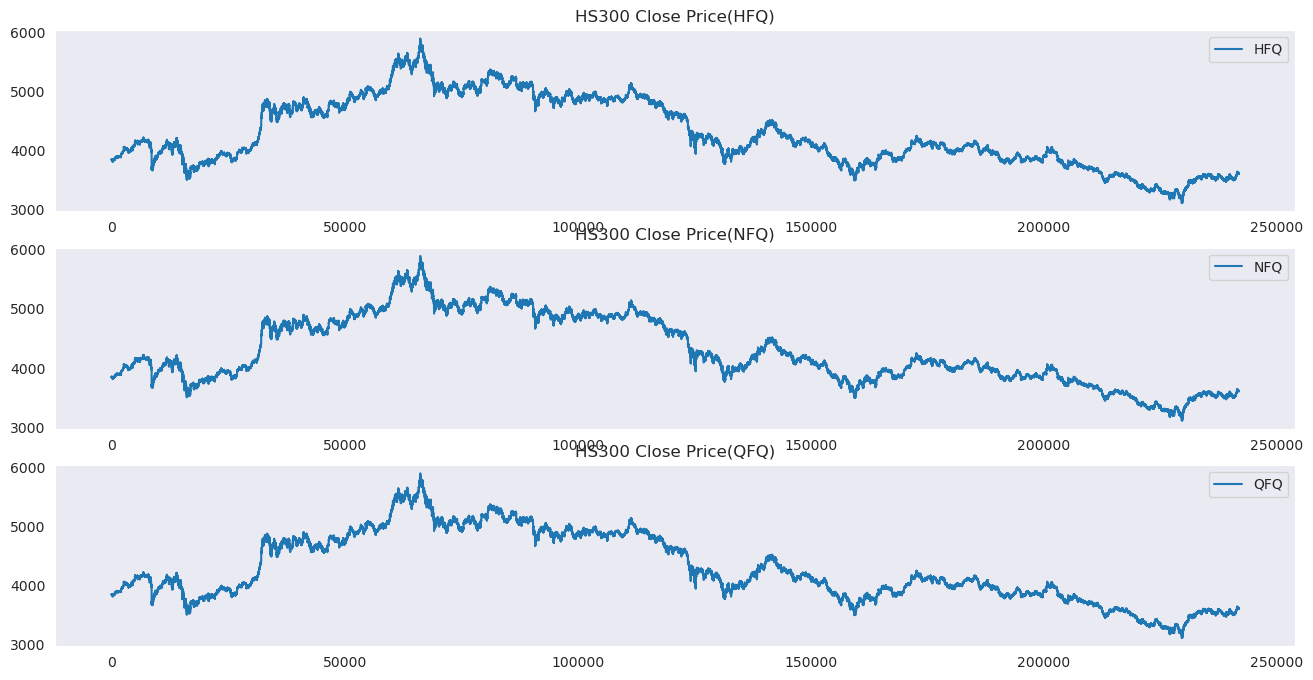

In [5]:
# 前复权、后复权、不复权数据的对比
fig = plt.figure(figsize=(16, 8))
# 3个子图
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

# 绘制前复权、后复权、不复权的收盘价
ax1.plot(hs300_hfq['close'], label='HFQ')
ax2.plot(hs300_nfq['close'], label='NFQ')
ax3.plot(hs300_qfq['close'], label='QFQ')

# 添加图例
ax1.legend()
ax2.legend()
ax3.legend()

# 添加标题
ax1.set_title('HS300 Close Price(HFQ)')
ax2.set_title('HS300 Close Price(NFQ)')
ax3.set_title('HS300 Close Price(QFQ)')

plt.show()

In [6]:
hs300_hfq

,time,open,close,high,low,volume,value
0,2019-12-02 09:34:00,3843.438,3845.393,3845.393,3843.438,80567900.0,1.242574e+09
1,2019-12-02 09:35:00,3845.025,3844.721,3846.084,3844.721,76499700.0,1.048426e+09
2,2019-12-02 09:36:00,3845.050,3842.752,3845.228,3842.752,74332600.0,1.006785e+09
3,2019-12-02 09:37:00,3842.621,3842.096,3842.666,3841.842,65161900.0,9.021498e+08
4,2019-12-02 09:38:00,3842.009,3838.729,3842.009,3838.729,72981600.0,9.490039e+08
...,...,...,...,...,...,...,...
241815,2024-04-30 14:52:00,3607.815,3607.129,3607.815,3607.118,75807300.0,1.271589e+09
241816,2024-04-30 14:53:00,3607.345,3607.166,3607.391,3606.751,89635900.0,1.449231e+09
241817,2024-04-30 14:54:00,3607.005,3606.686,3607.005,3606.443,94519900.0,1.521292e+09
241818,2024-04-30 14:55:00,3606.515,3606.260,3606.515,3605.959,107830500.0,1.779147e+09


In [7]:
# 计算不同列的相关性
hs300_hfq.drop(['time'], axis=1).corr()

,open,close,high,low,volume,value
open,1.000000,0.999993,0.999997,0.999997,0.215431,0.353924
close,0.999993,1.000000,0.999997,0.999997,0.215481,0.353962
high,0.999997,0.999997,1.000000,0.999996,0.216104,0.354590
low,0.999997,0.999997,0.999996,1.000000,0.214805,0.353294
volume,0.215431,0.215481,0.216104,0.214805,1.000000,0.930243
value,0.353924,0.353962,0.354590,0.353294,0.930243,1.000000


In [8]:
# 选取后复权数据，生成日度实现波动率
hs300_hfq['date'] = pd.to_datetime(hs300_hfq['time']).dt.date

def compute_daily_volatility(df):
    ddf = df.copy()
    ddf.sort_values('time', inplace=True)
    ddf['log_ret'] = np.log(ddf['close']) - np.log(ddf['close'].shift(1))
    ddf['sqr_log_ret'] = ddf['log_ret'] ** 2
    variance = np.sum(ddf['sqr_log_ret']) 
    return variance

realize_var = hs300_hfq.groupby('date').apply(compute_daily_volatility)

# realize_var转为DataFrame
realize_var = realize_var.to_frame()
realize_var.columns = ['realized_variance']
# 去掉为0的数据
realize_var = realize_var[realize_var['realized_variance'] > 0]
realize_var.reset_index(inplace=True, drop=False)
realize_var['log_realized_variance'] = np.log(realize_var['realized_variance'])
#realize_var.to_csv('dataset/rv.csv', index=False)
realize_var.describe()

,realized_variance,log_realized_variance
count,1070.000000,1070.000000
mean,0.000067,-9.858234
std,0.000061,0.659996
min,0.000010,-11.511667
25%,0.000032,-10.351168
50%,0.000051,-9.875926
75%,0.000079,-9.450303
max,0.000654,-7.333168


In [9]:
def compute_daily_volume(df):
    ddf = df.copy()
    ddf.sort_values('time', inplace=True)
    volume = np.sum(ddf['volume'])
    return volume

daily_volume = hs300_hfq.groupby('date').apply(compute_daily_volume)
daily_volume  = daily_volume .to_frame()
daily_volume.columns = ['daily_volume']
daily_volume.reset_index(inplace=True, drop=False)
daily_volume['log_daily_volume'] = np.log(daily_volume['daily_volume'])
daily_volume.describe()

,daily_volume,log_daily_volume
count,1.070000e+03,1070.000000
mean,1.268236e+10,23.221188
std,3.901405e+09,0.286225
min,5.812504e+09,22.483277
25%,9.876086e+09,23.013381
50%,1.207442e+10,23.214355
75%,1.462615e+10,23.406077
max,3.527450e+10,24.286426


In [10]:
dataset = pd.merge(realize_var, daily_volume, on='date', how='inner')
dataset.describe()

,realized_variance,log_realized_variance,daily_volume,log_daily_volume
count,1070.000000,1070.000000,1.070000e+03,1070.000000
mean,0.000067,-9.858234,1.268236e+10,23.221188
std,0.000061,0.659996,3.901405e+09,0.286225
min,0.000010,-11.511667,5.812504e+09,22.483277
25%,0.000032,-10.351168,9.876086e+09,23.013381
50%,0.000051,-9.875926,1.207442e+10,23.214355
75%,0.000079,-9.450303,1.462615e+10,23.406077
max,0.000654,-7.333168,3.527450e+10,24.286426


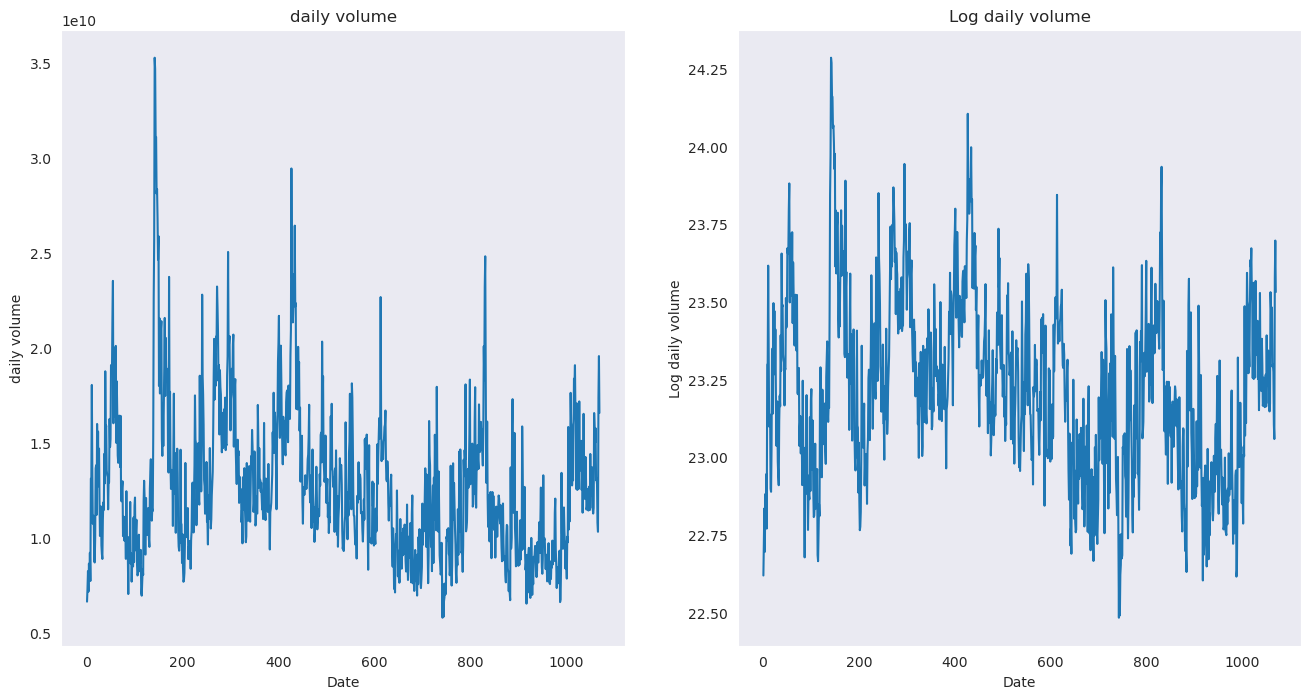

In [50]:
# realized_variance 和 log_realized_variance 左右子图
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(dataset['daily_volume'])
ax1.set_title('daily volume')
ax1.set_xlabel('Date')
ax1.set_ylabel('daily volume')

ax2.plot(dataset['log_daily_volume'])
ax2.set_title('Log daily volume')
ax2.set_xlabel('Date')
ax2.set_ylabel('Log daily volume')

plt.show()

## 2 数据分析

In [11]:
# 80% 训练集，20% 测试集
train_size= int(len(dataset) * 0.8)
train, test = dataset.iloc[:train_size], dataset.iloc[train_size:]
train.shape, test.shape

((856, 5), (214, 5))

In [54]:
train

,date,realized_variance,log_realized_variance,daily_volume,log_daily_volume,lag1_log_daily_volume,residuals
1,2019-12-03,0.000019,-10.888601,6.659130e+09,22.619255,22.658333,-0.522566
2,2019-12-04,0.000014,-11.170075,7.349651e+09,22.717919,22.619255,-0.766975
3,2019-12-05,0.000021,-10.755064,8.262728e+09,22.835021,22.717919,-0.445546
4,2019-12-06,0.000012,-11.370465,7.185782e+09,22.695370,22.835021,-1.172017
5,2019-12-09,0.000017,-11.007490,8.657060e+09,22.881641,22.695370,-0.676585
...,...,...,...,...,...,...,...
851,2023-06-06,0.000046,-9.977586,1.150477e+10,23.166028,23.067305,0.000542
852,2023-06-07,0.000047,-9.960931,8.977903e+09,22.918032,23.166028,-0.076440
853,2023-06-08,0.000066,-9.620473,1.093483e+10,23.115219,22.918032,0.499239
854,2023-06-09,0.000043,-10.055955,1.165780e+10,23.179241,23.115219,-0.123273


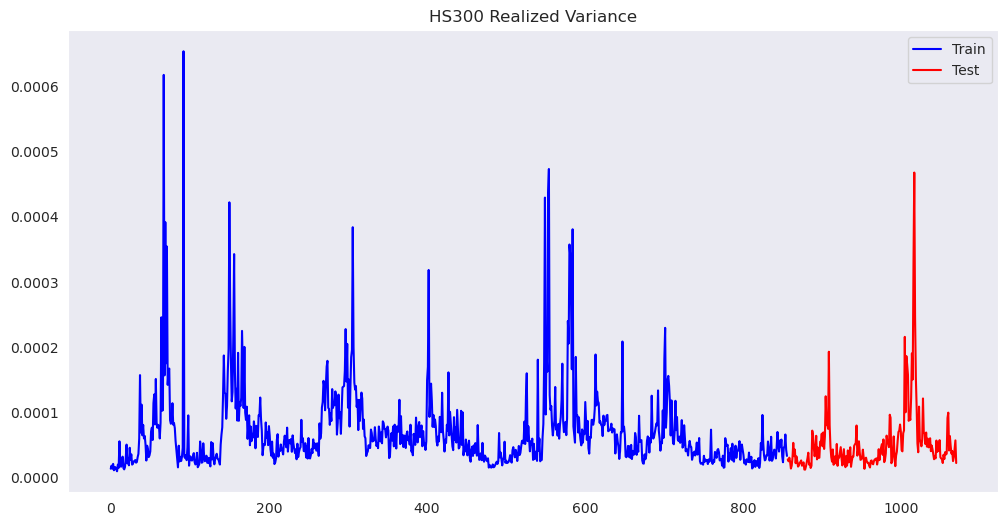

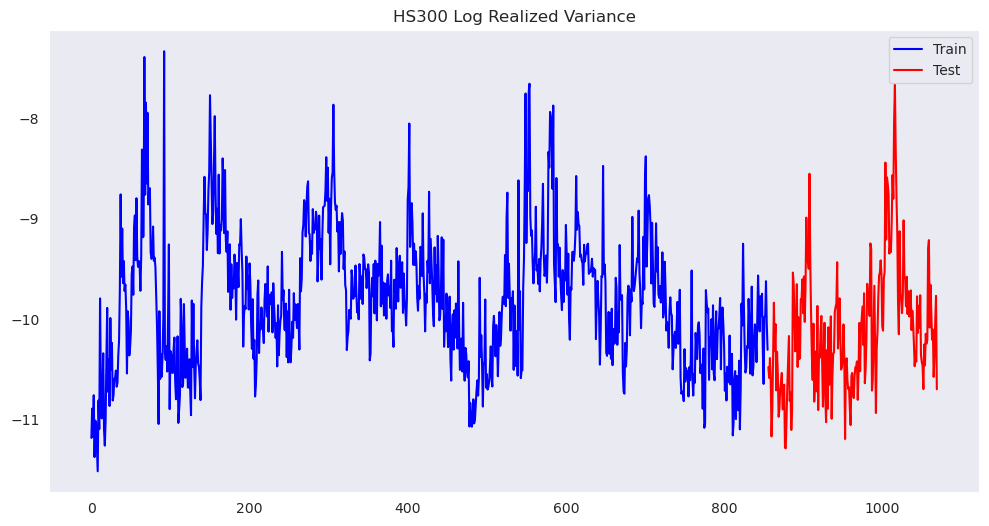

In [12]:
# realize_var的分布
fig = plt.figure(figsize=(12, 6))
plt.plot(train.realized_variance, label='Train', color='blue')
plt.plot(test.realized_variance, label='Test', color='red')
plt.legend()
plt.title('HS300 Realized Variance')
plt.show()

train['log_realized_variance'] = np.log(train['realized_variance'])
test['log_realized_variance'] = np.log(test['realized_variance'])
fig = plt.figure(figsize=(12, 6))
plt.plot(train.log_realized_variance, label='Train', color='blue')
plt.plot(test.log_realized_variance, label='Test', color='red')
plt.legend()
plt.title('HS300 Log Realized Variance')
plt.show()

In [13]:
# log_realized_variance 的 ADF检验
result = adfuller(train['log_realized_variance'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.523119
p-value: 0.000179


In [14]:
# log_realized_variance 的 白噪声检验
result = acorr_ljungbox(train['log_realized_variance'])
result

,lb_stat,lb_pvalue
1,488.043736,3.797298e-108
2,921.039322,9.973611e-201
3,1281.633024,1.422608e-277
4,1601.398219,0.000000e+00
5,1892.039489,0.000000e+00
6,2153.583250,0.000000e+00
7,2380.377497,0.000000e+00
8,2596.567745,0.000000e+00
9,2807.512456,0.000000e+00
10,2990.666319,0.000000e+00


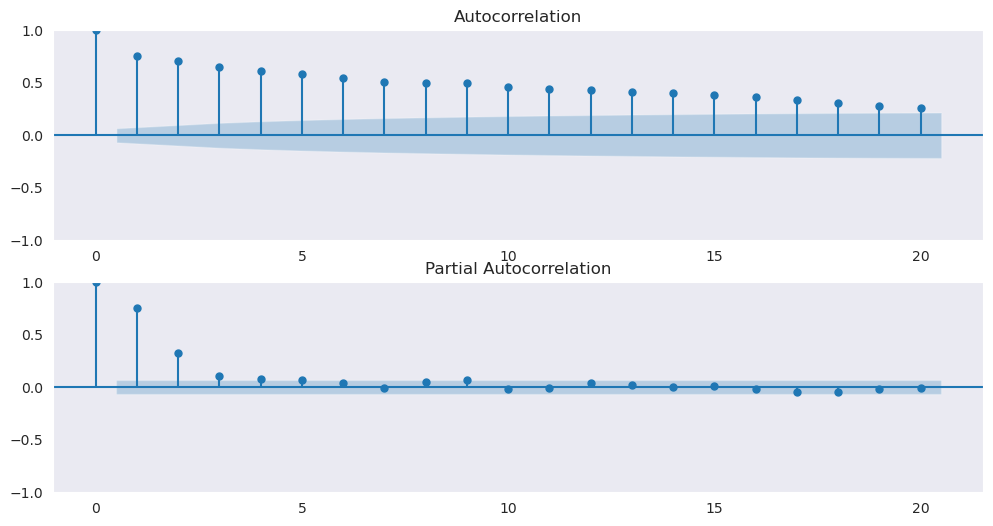

In [15]:
# log_realized_variance的 ACF，PACF
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

plot_acf(train['log_realized_variance'], lags=20, ax=ax1)
plot_pacf(train['log_realized_variance'], lags=20, ax=ax2)

plt.show()

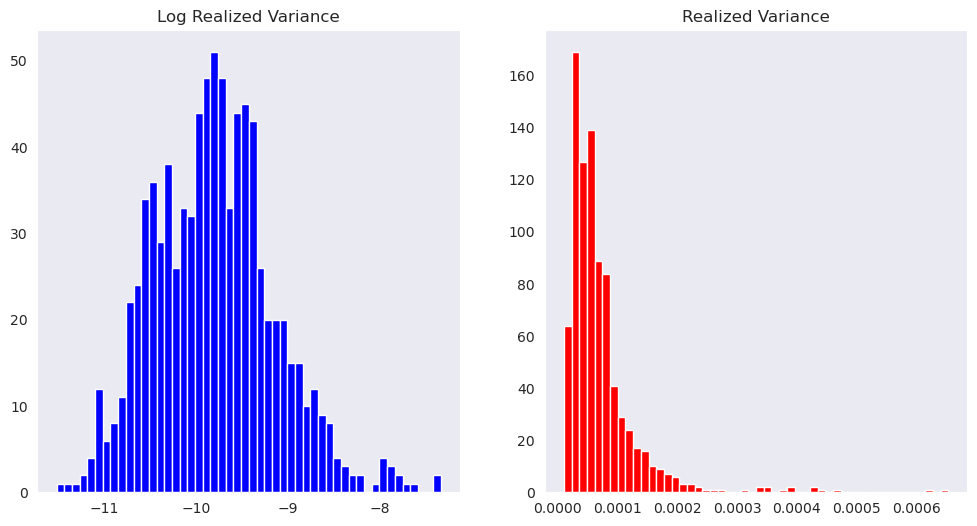

In [16]:
fig = plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.hist(train['log_realized_variance'].values, bins=50, color='blue')
plt.title('Log Realized Variance')
plt.subplot(122)
plt.hist(train['realized_variance'].values, bins=50, color='red')
plt.title('Realized Variance')
plt.show()

## 3 ARMA

In [17]:
# ARMA模型定阶
order_analyze = st.arma_order_select_ic(train['log_realized_variance'], max_ar=6, max_ma=6, ic=['aic', 'bic'])
order_analyze

{'aic':              0            1            2            3            4  \
 0  1713.146212  1350.645524  1165.255743  1074.200183  1034.551300   
 1   990.575081   874.045394   875.900413   872.713268   874.099454   
 2   893.455663   875.823620   877.682690   874.047689   875.982382   
 3   885.101977   872.077344   874.075526   874.978883   875.563504   
 4   881.720129   874.075211   876.070876   875.427592   872.557794   
 5   878.558140   875.996933   877.632402   877.420262   877.236177   
 6   878.744050   880.714714   879.780851   873.291414   876.584021   
 
             5           6  
 0  996.317808  963.289658  
 1  876.092169  877.604711  
 2  878.073267  879.258243  
 3  872.485894  875.309060  
 4  871.986119  874.246711  
 5  879.267425  877.852530  
 6  880.641754  879.268085  ,
 'bic':              0            1            2            3            4  \
 0  1722.650753  1364.902335  1184.264825  1097.961535  1063.064922   
 1  1004.831893   893.054476   899.661765

In [55]:
# 使用得到的最优阶数进行ARMA拟合
arma_model_aic = sm.tsa.ARIMA(train['log_realized_variance'], order=(4, 0, 5)).fit()
arma_model_bic = sm.tsa.ARIMA(train['log_realized_variance'], order=(1, 0, 1)).fit()

In [56]:
arma_model_aic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:     log_realized_variance   No. Observations:                  855
Model:                    ARIMA(4, 0, 5)   Log Likelihood                -424.498
Date:                   Sat, 15 Jun 2024   AIC                            870.996
Time:                           23:57:52   BIC                            923.258
Sample:                                0   HQIC                           891.010
                                   - 855                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.8520      0.176    -55.864      0.000     -10.198      -9.506
ar.L1          0.9066      0.267      3.390      0.001       0.382       1.431
ar.L2         -0.4881      0.084     -5.827      0.000      -0.652      -0.324
ar.L3          1.1158      0.084     13.345      0.000       0.952       1.280
ar.L4         -0.5624      0.244     -2.300      0.021      -1.041      -0.083
ma.L1         -0.4525      0.270     -1.679      0.093      -0.981       0.076
ma.L2          0.5267      0.063      8.393      0.000       0.404       0.650
ma.L3         -0.9493      0.146     -6.483      0.000      -1.236      -0.662
ma.L4          0.2604      0.155      1.678      0.093      -0.044       0.564
ma.L5         -0.0311      0.049     -0.633      0.527      -0.127       0.065
sigma2         0.1571      0.005     30.024      0.000       0.147       0.167
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               507.82
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
arma_model_bic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:     log_realized_variance   No. Observations:                  855
Model:                    ARIMA(1, 0, 1)   Log Likelihood                -432.671
Date:                   Sat, 15 Jun 2024   AIC                            873.341
Time:                           23:58:00   BIC                            892.346
Sample:                                0   HQIC                           880.619
                                   - 855                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.8233      0.123    -80.156      0.000     -10.063      -9.583
ar.L1          0.9398      0.013     73.541      0.000       0.915       0.965
ma.L1         -0.4933      0.026    -18.902      0.000      -0.544      -0.442
sigma2         0.1609      0.005     32.403      0.000       0.151       0.171
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               609.56
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                             0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

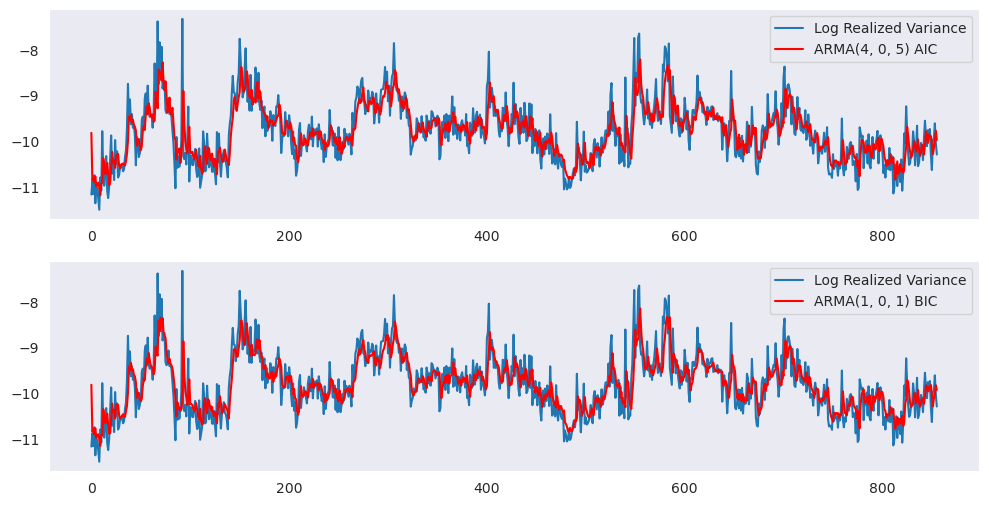

In [21]:
# 对比AIC和BIC的样本内拟合效果
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(train['log_realized_variance'], label='Log Realized Variance')
ax1.plot(arma_model_aic.fittedvalues, label='ARMA(4, 0, 5) AIC', color='red')
ax1.legend()
ax2.plot(train['log_realized_variance'], label='Log Realized Variance')
ax2.plot(arma_model_bic.fittedvalues, label='ARMA(1, 0, 1) BIC', color='red')
ax2.legend()
plt.show()

In [22]:
# 残差的白噪声检验
residuals = arma_model_bic.resid
result = acorr_ljungbox(residuals)
result

,lb_stat,lb_pvalue
1,0.005376,0.941551
2,0.482571,0.785617
3,2.855756,0.414403
4,4.187385,0.381240
5,4.311151,0.505541
6,4.338995,0.630904
7,6.751141,0.455243
8,6.792401,0.559188
9,9.287829,0.411141
10,9.313682,0.502615


In [23]:
# 样本外滚动预测
def rolling_predict(model, train, test):
    test = test.reset_index(drop=True)
    history = [x for x in train]
    predictions = list()
    for i in tqdm(range(len(test))):
        model = sm.tsa.ARIMA(history, order=(1, 0, 1)).fit()
        yhat = model.forecast()[0]
        predictions.append(yhat)
        history.append(test[i])
    return predictions

In [24]:
#predictions_aic = rolling_predict(arma_model_aic, train['log_realized_variance'], test['log_realized_variance'])
predictions_arma = rolling_predict(arma_model_bic, train['log_realized_variance'], test['log_realized_variance'])

100%|██████████| 214/214 [01:16<00:00,  2.78it/s]


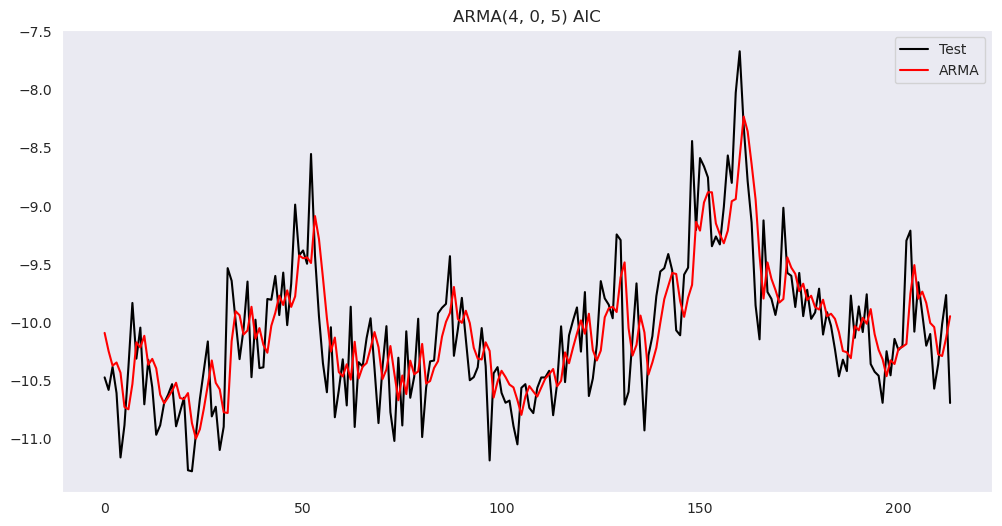

In [25]:
fig = plt.figure(figsize=(12, 6))
plt.plot(test['log_realized_variance'].reset_index(drop=True), label='Test', color='black')
plt.plot(predictions_arma, label='ARMA', color='red')
#plt.plot(test['log_realized_variance'].shift(1).reset_index(drop=True), label='Lagged', color='blue', alpha=0.5)    
plt.legend()
plt.title('ARMA(4, 0, 5) AIC')
plt.show()

In [26]:
# 残差检验
residuals_aic = test['log_realized_variance'] - np.array(predictions_arma)
# lb检验 of residuals
result = acorr_ljungbox(residuals_aic, lags=5)
result

,lb_stat,lb_pvalue
1,2.211989,0.136942
2,3.068060,0.215665
3,4.092095,0.251690
4,4.535398,0.338371
5,4.905756,0.427490


## 4 基于粗糙波动率模型的预测

In [27]:
def dlsig2(sic, x, pr=False):
    if pr:
        a= np.array([(sig-sig.shift(lag)).dropna() for lag in x])
        a=a ** 2
        print(a.info())
    return [np.mean((sig-sig.shift(lag)).dropna() ** 2) for lag in x]

h = list()
nu = list()

x = np.arange(1, 100)
sig = train.realized_variance
sig = np.log(np.sqrt(sig))
sig = sig.dropna()
model = np.polyfit(np.log(x), np.log(dlsig2(sig, x)), 1)
model

array([ 0.32160539, -2.85847268])

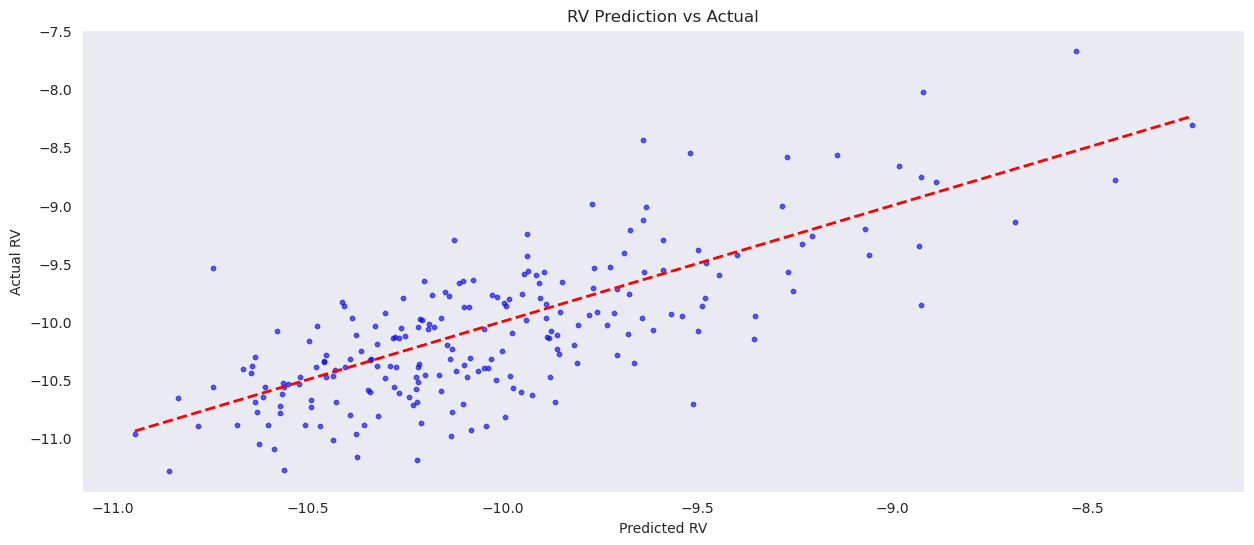

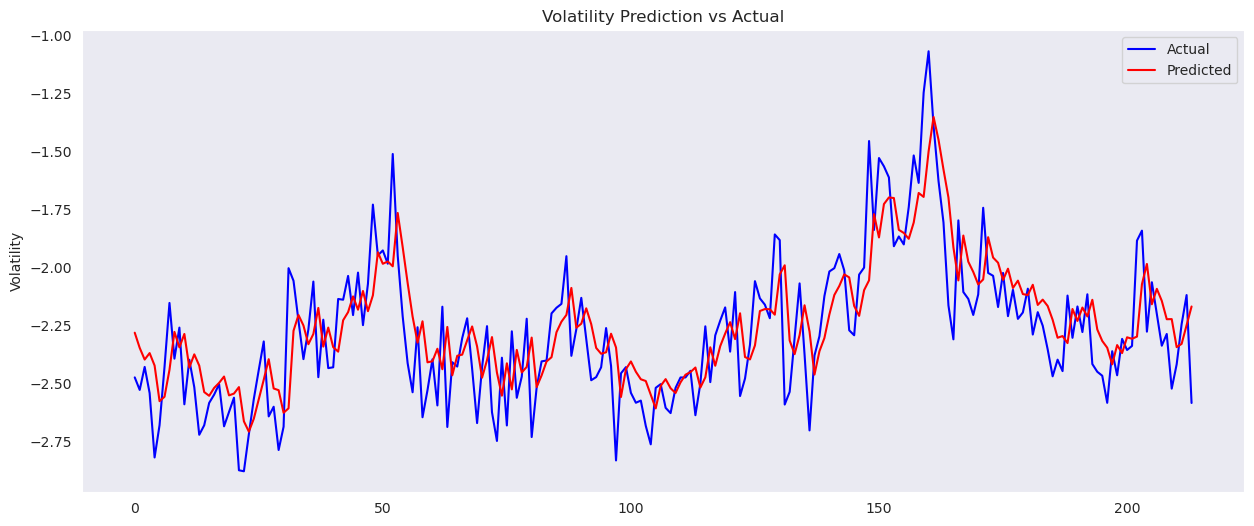

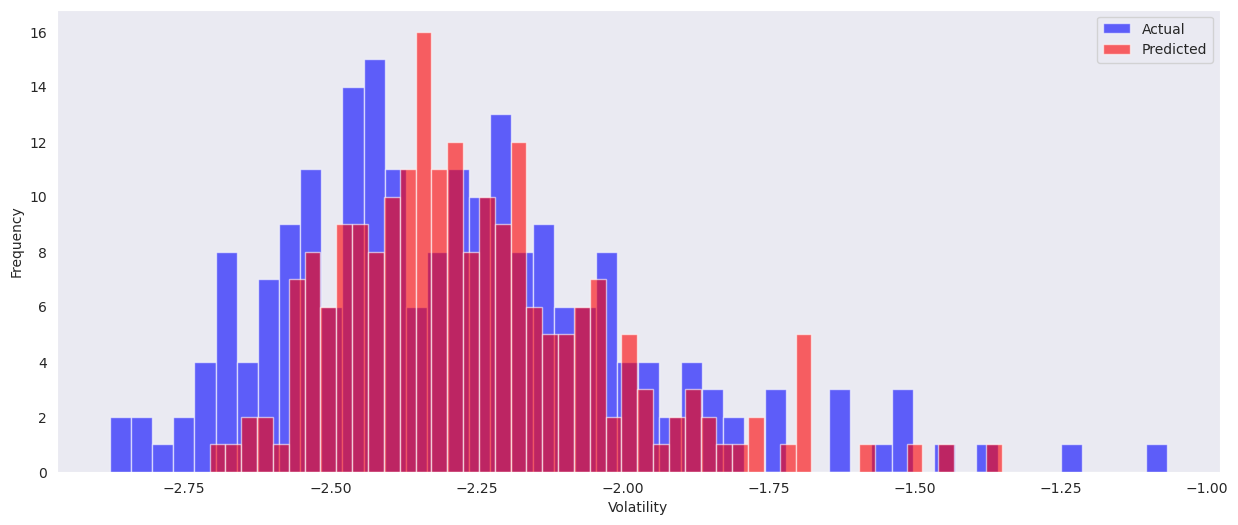

In [28]:
def c_tilde(h):
    return scsp.gamma(3. / 2. - h) / scsp.gamma(h + 1. / 2.) * scsp.gamma(2. - 2. * h)

def forecast_XTS(rvdata, h, date, nLags, delta, nu):
    i = np.arange(nLags)
    cf = 1./((i + 1. / 2.) ** (h + 1. / 2.) * (i + 1. / 2. + delta))
    ldata = rvdata.truncate(after=date)
    l = len(ldata)
    ldata = np.log(ldata.iloc[l - nLags:])
    ldata['cf'] = np.fliplr([cf])[0]
    # print ldata
    ldata = ldata.dropna()
    fcst = (ldata.iloc[:, 0] * ldata['cf']).sum() / sum(ldata['cf'])
    
    return math.exp(fcst + 2 * nu ** 2 * c_tilde(h) * delta ** (2 * h))

rvdata = pd.DataFrame(realize_var[['realized_variance', 'date']])
rvdata = rvdata.set_index('date')
nu  = np.sqrt(np.exp(model[1])) # Vol of vol estimate for SPX
h = model[0]/2.
n = len(rvdata)
delta = 1
nLags = n - len(predictions_arma)-1
dates = rvdata.iloc[nLags:n-delta].index
predictions_roughVol = [forecast_XTS(rvdata, h=h, date=d, nLags=nLags,
                           delta=delta, nu=nu) for d in dates]
rv_actual = rvdata.iloc[nLags+delta:n].values

plt.figure(figsize=(15, 6))
plt.scatter(np.log(predictions_roughVol), np.log(rv_actual), color='blue', alpha=0.6, s=10)
# diagonal line
plt.plot([np.min(np.log(predictions_roughVol)), np.max(np.log(predictions_roughVol))],
         [np.min(np.log(predictions_roughVol)), np.max(np.log(predictions_roughVol))], 'r--', lw=2)
plt.xlabel('Predicted RV')
plt.ylabel('Actual RV')
plt.title('RV Prediction vs Actual')
plt.show()

vol_actual = np.log(np.sqrt(np.multiply(rv_actual,252)))
vol_predict = np.log(np.sqrt(np.multiply(predictions_roughVol,252)))
plt.figure(figsize=(15, 6))
plt.plot(vol_actual, color='blue', label='Actual')
plt.plot(vol_predict, color='red', label='Predicted')
plt.ylabel('Volatility')
plt.legend()
plt.title('Volatility Prediction vs Actual')
plt.show()

# 分布对比
plt.figure(figsize=(15, 6))
plt.hist(vol_actual, bins=50, color='blue', alpha=0.6, label='Actual')
plt.hist(vol_predict, bins=50, color='red', alpha=0.6, label='Predicted')
plt.xlabel('Volatility')
plt.ylabel('Frequency')
plt.legend()
plt.show()

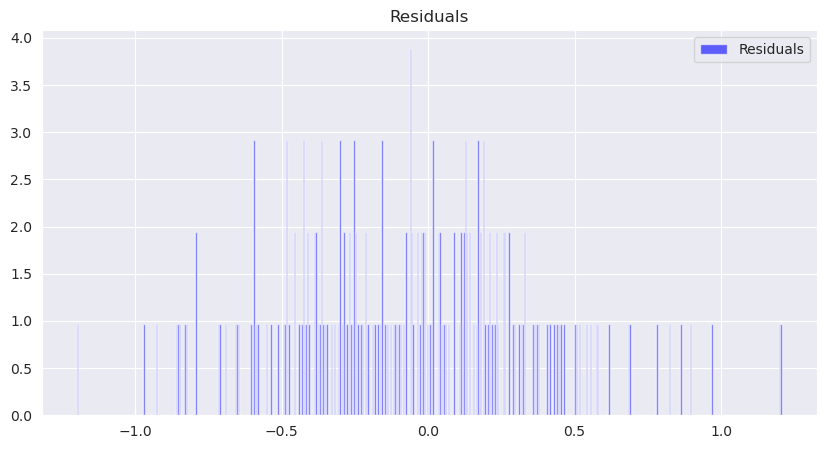

,lb_stat,lb_pvalue
1,1.196813,0.273960
2,1.207162,0.546850
3,1.217596,0.748787
4,1.227626,0.873530
5,3.193924,0.670117
6,6.136442,0.408081
7,7.682106,0.361458
8,8.056315,0.427989
9,15.425147,0.079901
10,15.710097,0.108237


In [29]:
# 残差检验
residuals = np.log(rv_actual.flatten() / predictions_roughVol)
fig = plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=500, color='blue', alpha=0.6, label='Residuals', density=True)
plt.title('Residuals')
plt.grid()
plt.legend()
plt.show()

# Ljung-Box检验
lb_test_stat = acorr_ljungbox(residuals, lags=10)
lb_test_stat

## 5 外生性预测

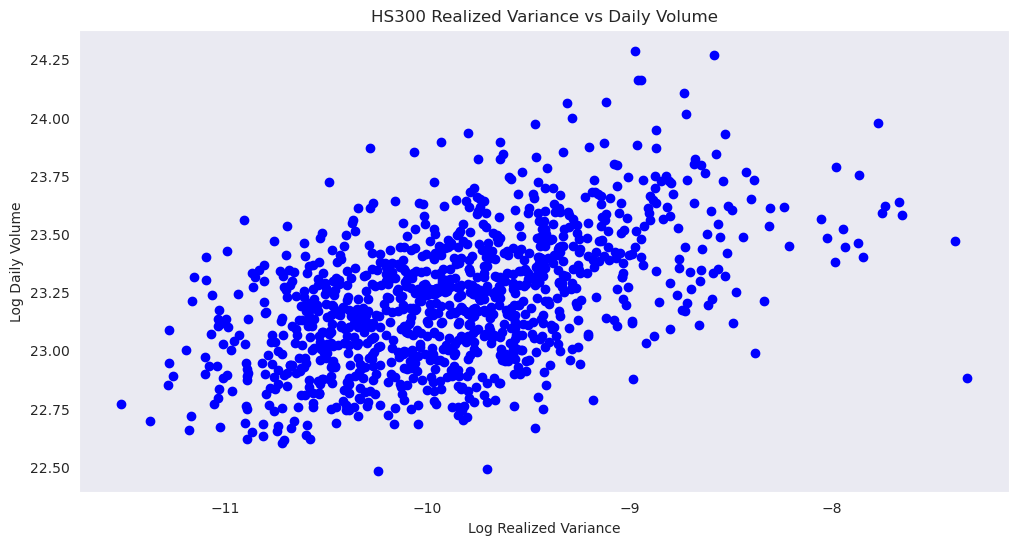

In [30]:
fig = plt.figure(figsize=(12, 6))
plt.scatter(dataset['log_realized_variance'], dataset['log_daily_volume'], color='blue')
plt.xlabel('Log Realized Variance')
plt.ylabel('Log Daily Volume')
plt.title('HS300 Realized Variance vs Daily Volume')
plt.show()

In [31]:
dataset['lag1_log_daily_volume'] = dataset['log_daily_volume'].shift(1)
dataset.dropna(inplace=True)
# 80% 训练集，20% 测试集
train_size= int(len(dataset) * 0.8)
train, test = dataset.iloc[:train_size], dataset.iloc[train_size:]
train.shape, test.shape

((855, 6), (214, 6))

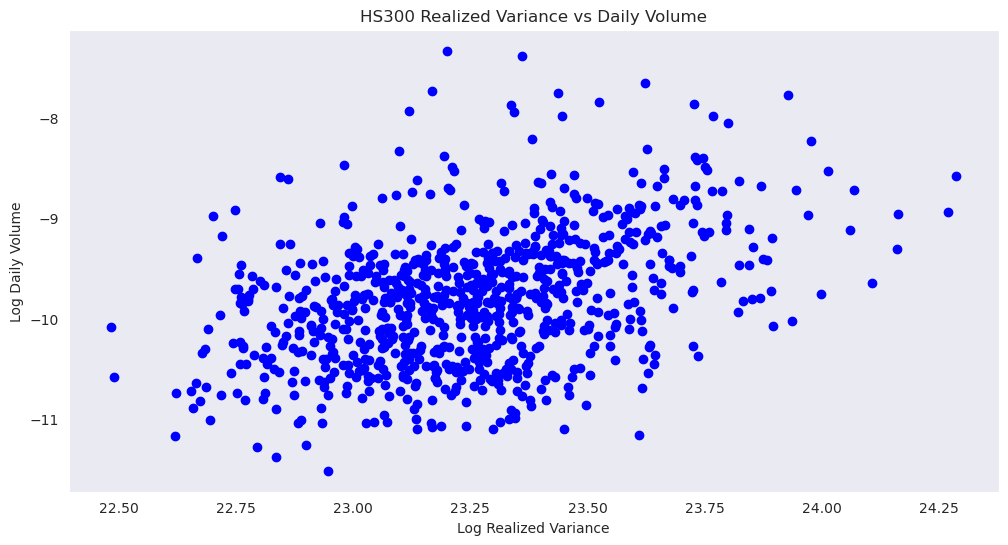

In [32]:
fig = plt.figure(figsize=(12, 6))
plt.scatter(train['lag1_log_daily_volume'], train['log_realized_variance'], color='blue')
plt.xlabel('Log Realized Variance')
plt.ylabel('Log Daily Volume')
plt.title('HS300 Realized Variance vs Daily Volume')
plt.show()

In [33]:
X = train['lag1_log_daily_volume']
X_test = test['lag1_log_daily_volume']
y = train['log_realized_variance']
y_test = test['log_realized_variance']

X = sm.add_constant(X)
X_test = sm.add_constant(X_test)
model = OLS(y, X).fit()
y_pred0 = model.predict(X_test)
y_pred = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     log_realized_variance   R-squared:                       0.169
Model:                               OLS   Adj. R-squared:                  0.168
Method:                    Least Squares   F-statistic:                     173.5
Date:                   Sat, 15 Jun 2024   Prob (F-statistic):           3.40e-36
Time:                           13:57:49   Log-Likelihood:                -772.72
No. Observations:                    855   AIC:                             1549.
Df Residuals:                        853   BIC:                             1559.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -31.8572      1.675    -19.019      0.000     -35.145     -28.570
lag1_log_daily_volume     0.9485      0.072     13.171      0.000       0.807       1.090
==============================================================================
Omnibus:                       31.639   Durbin-Watson:                   0.715
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.643
Skew:                           0.377   Prob(JB):                     1.49e-09
Kurtosis:                       3.756   Cond. No.                     1.91e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

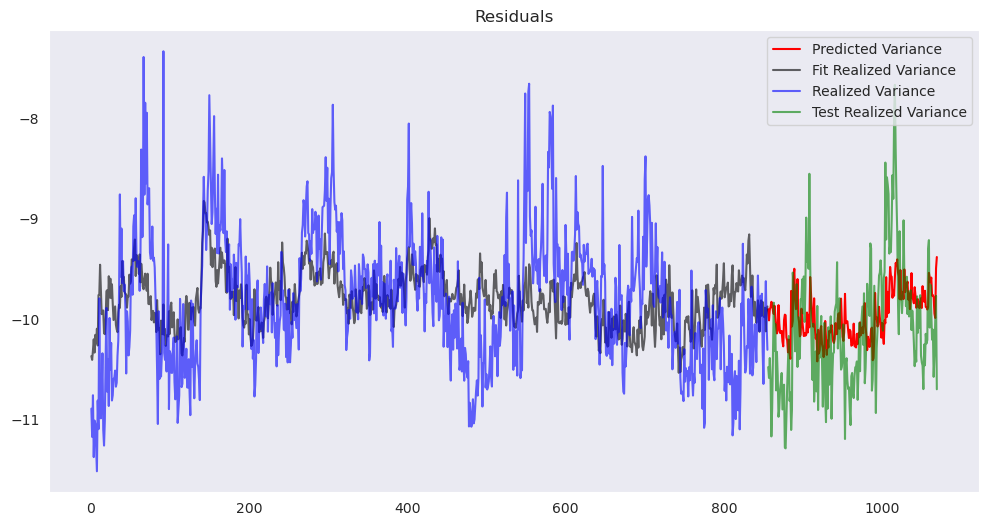

In [34]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y_pred0, color='red', label='Predicted Variance')
plt.plot(y_pred, color='black', alpha=0.6, label='Fit Realized Variance')
plt.plot(y, color='blue', alpha=0.6, label='Realized Variance')
plt.plot(y_test, color='green', alpha=0.6, label='Test Realized Variance')
plt.title('Residuals')
plt.legend()
plt.show()

In [35]:
assert len(y) == len(y_pred)
assert len(y_test) == len(y_pred0)
train['residuals'] = y - y_pred
test['residuals'] = y_test - y_pred0

In [36]:
# 拟合残差
residuals = y - y_pred
# 平稳性检验
result = adfuller(residuals)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# 白噪声检验
result = acorr_ljungbox(residuals)
result

ADF Statistic: -4.326506
p-value: 0.000400


,lb_stat,lb_pvalue
1,353.544188,7.167265e-79
2,700.502120,7.724979e-153
3,981.174841,2.181954e-212
4,1241.158633,1.902496e-267
5,1479.715257,0.000000e+00
6,1689.136712,0.000000e+00
7,1871.107237,0.000000e+00
8,2046.312970,0.000000e+00
9,2227.670111,0.000000e+00
10,2389.412403,0.000000e+00


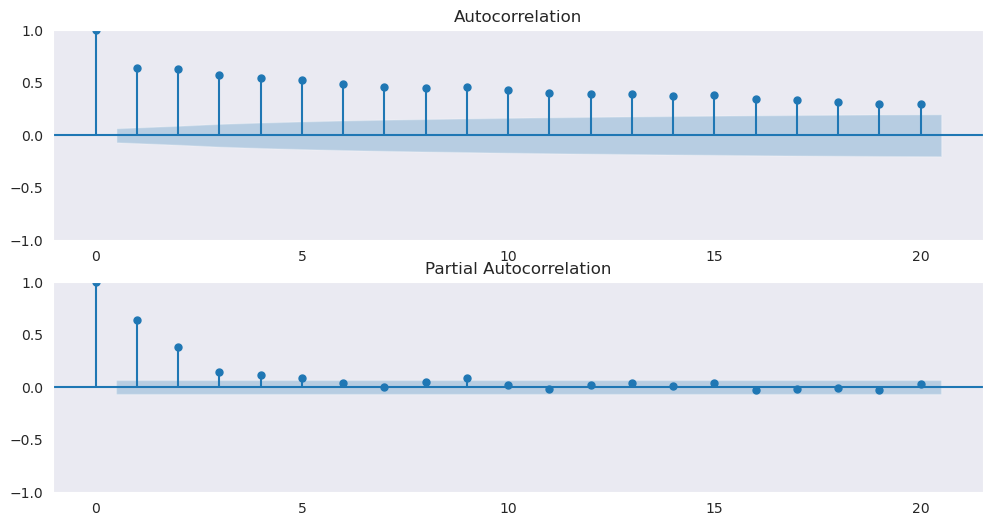

In [37]:
# residuals的ACF和PACF
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

plot_acf(residuals, lags=20, ax=ax1)
plot_pacf(residuals, lags=20, ax=ax2)

plt.show()

In [38]:
# ARMA模型定阶
order_analyze = st.arma_order_select_ic(residuals, max_ar=6, max_ma=6, ic=['aic', 'bic'])

In [39]:
order_analyze

{'aic':              0            1            2            3            4  \
 0  1549.447406  1314.942781  1162.971300  1107.400053  1070.946690   
 1  1096.966755   927.733174   929.333015   925.677768   927.671649   
 2   964.728424   929.190821   929.185100   927.666601   929.053804   
 3   947.815881   925.119888   927.035552   928.743783   930.776194   
 4   938.487064   927.064495   929.099897   933.627966   932.713188   
 5   933.485675   928.831835   930.896432   932.273557   929.301628   
 6   934.187214   930.349984   932.449856   930.771351   933.399358   
 
              5            6  
 0  1032.267363  1009.825936  
 1   929.347519   929.564425  
 2   930.349331   931.273253  
 3   928.980300   929.751073  
 4   929.598060   930.666358  
 5   931.529509   932.717212  
 6   935.507000   934.145028  ,
 'bic':              0            1            2            3            4  \
 0  1558.949609  1329.196086  1181.975706  1131.155560  1099.453299   
 1  1111.220060   946.737

In [40]:
# ARMA（1，1）
arma_model = sm.tsa.ARIMA(residuals, order=(1, 0, 1)).fit()
arma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  855
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -459.867
Date:                Sat, 15 Jun 2024   AIC                            927.733
Time:                        13:58:49   BIC                            946.738
Sample:                             0   HQIC                           935.011
                                - 855                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0175      0.116     -0.150      0.881      -0.245       0.210
ar.L1          0.9530      0.012     78.286      0.000       0.929       0.977
ma.L1         -0.6379      0.028    -22.842      0.000      -0.693      -0.583
sigma2         0.1715      0.006     29.743      0.000       0.160       0.183
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):               344.97
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                             0.73
Prob(H) (two-sided):                  0.10   Kurtosis:                         5.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
# 残差的白噪声检验
resid = arma_model.resid
result = acorr_ljungbox(resid)
result

,lb_stat,lb_pvalue
1,0.129948,0.718486
2,3.339682,0.188277
3,4.503214,0.212004
4,4.674427,0.322363
5,4.682906,0.455790
6,5.265226,0.510273
7,8.229125,0.312824
8,9.072142,0.336247
9,10.372444,0.321183
10,10.430095,0.403603


In [42]:
# 样本外滚动预测
def rolling_predict(model, train, test):
    test = test.reset_index(drop=True)
    history = [x for x in train]
    predictions = list()
    for i in tqdm(range(len(test))):
        model = sm.tsa.ARIMA(history, order=(1, 0, 1)).fit()
        yhat = model.forecast()[0]
        predictions.append(yhat)
        history.append(test[i])
    return predictions

predictions = rolling_predict(arma_model, train['residuals'], test['residuals'])

  0%|          | 0/214 [00:00<?, ?it/s]

100%|██████████| 214/214 [01:24<00:00,  2.53it/s]


In [43]:
# 残差检验
resids = test['residuals'] - np.array(predictions)
result = acorr_ljungbox(resids, lags=5)
result

,lb_stat,lb_pvalue
1,2.203894,0.137663
2,2.299528,0.316711
3,3.065447,0.381644
4,3.514234,0.475717
5,3.608061,0.607103


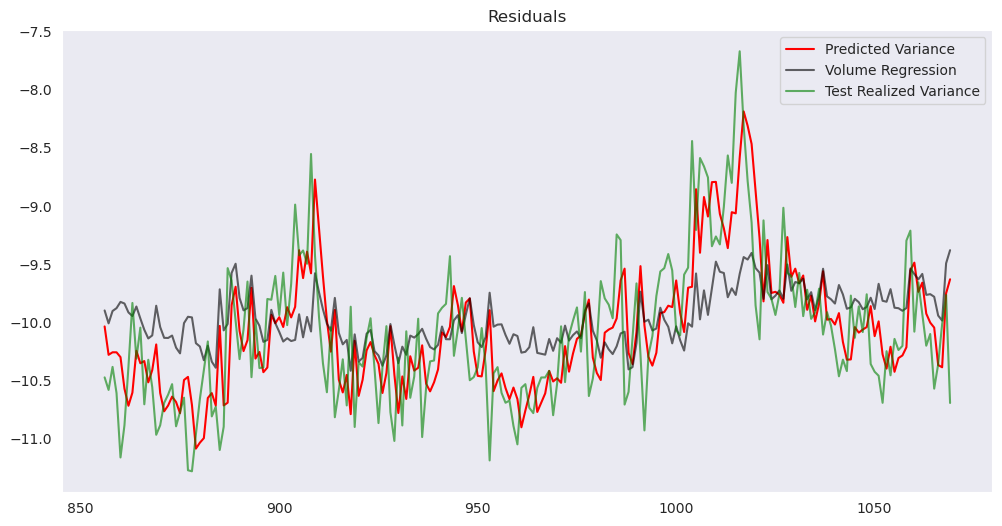

In [44]:
# 还原预测值 = 预测值 + 残差
y_pred_final = y_pred0 + np.array(predictions)

fig = plt.figure(figsize=(12, 6))
plt.plot(y_pred_final, color='red', label='Predicted Variance')
plt.plot(y_pred0, color='black', alpha=0.6, label='Volume Regression')
plt.plot(y_test, color='green', alpha=0.6, label='Test Realized Variance')
plt.title('Residuals')
plt.legend()
plt.show()

## 6 综合比较

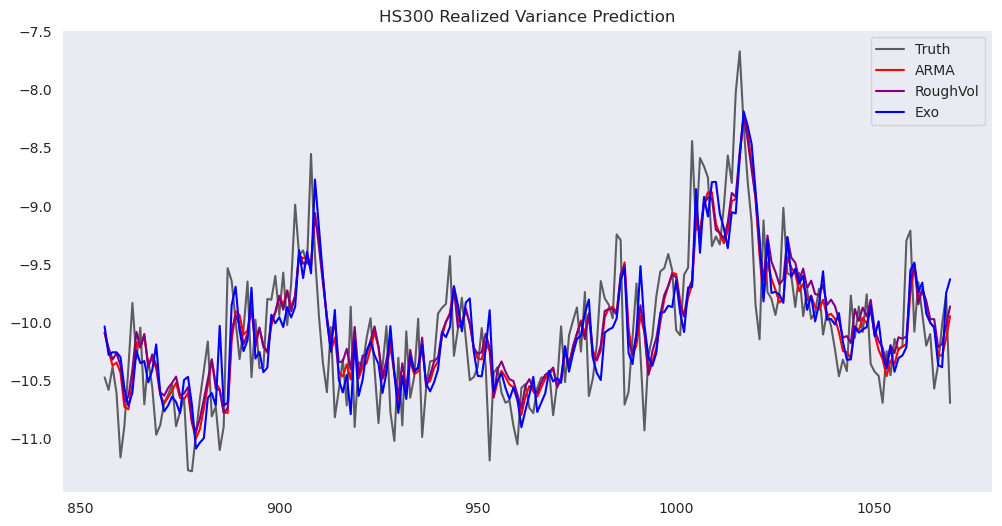

In [45]:
predictions_df = pd.DataFrame({'ARMA': predictions_arma, 'RoughVol': np.log(predictions_roughVol), 'exo': y_pred_final, 'truth': y_test})

fig = plt.figure(figsize=(12, 6))
plt.plot(predictions_df['truth'], color='black', label='Truth', alpha=0.6)
plt.plot(predictions_df['ARMA'], color='red', label='ARMA')
plt.plot(predictions_df['RoughVol'], color='purple', label='RoughVol')
plt.plot(predictions_df['exo'], color='blue', label='Exo')
plt.legend()
plt.title('HS300 Realized Variance Prediction')
plt.show()

In [46]:
def critieria(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs(y_true - y_pred) / y_true)
    RSquare = 1 - mse / np.var(y_true)
    diff_y_pred = np.diff(y_pred)
    diff_y_true = np.diff(y_true)
    precision = np.sum(np.sign(diff_y_pred) == np.sign(diff_y_true)) / len(diff_y_true)
    recall = np.sum(np.sign(diff_y_pred) == np.sign(diff_y_true)) / np.sum(np.sign(diff_y_true) != 0)
    return mse, mae, mape, RSquare, precision, recall

mse_list = []
mae_list = []
mape_list = []
RSquare_list = []
precision_list = []
recall_list = []

for col in predictions_df.columns:
    mse, mae, mape, RSquare, precision, recall = critieria(predictions_df['truth'], predictions_df[col])
    mse_list.append(mse)
    mae_list.append(mae)
    mape_list.append(mape)
    RSquare_list.append(RSquare)
    precision_list.append(precision)
    recall_list.append(recall)

result_df = pd.DataFrame({'Model': predictions_df.columns, 'MSE': mse_list, 'MAE': mae_list, 'MAPE': mape_list, 'RSquare': RSquare_list, 'Precision': precision_list, 'Recall': recall_list})
result_df

,Model,MSE,MAE,MAPE,RSquare,Precision,Recall
0,ARMA,0.168779,0.324927,-0.032605,0.559190,0.380282,0.380282
1,RoughVol,0.171389,0.330061,-0.033007,0.552376,0.403756,0.403756
2,exo,0.215084,0.367220,-0.036872,0.438255,0.366197,0.366197
3,truth,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000


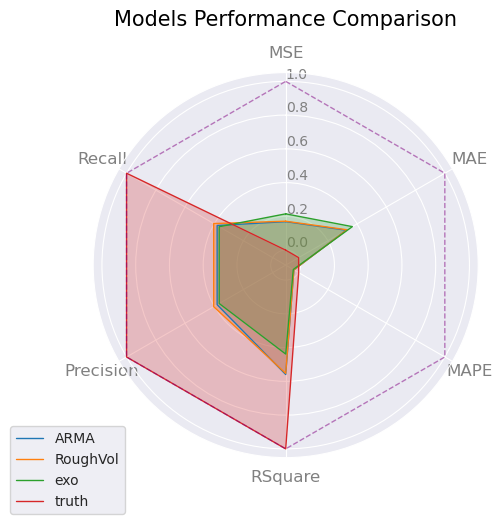

In [47]:
df = result_df

indicators = ["MSE", "MAE", "MAPE", "RSquare", "Precision", "Recall"]
models = df["Model"]
labels = ["MSE", "MAE", "MAPE", "RSquare", "Precision", "Recall"]

def create_hexagon_radar_chart(data, labels, models, title):
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    
    plt.xticks(angles[:-1], labels, color='grey', size=12)
    ax.tick_params(colors='grey')

    for i, model in enumerate(models):
        values = data.iloc[i, 1:].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=model)
        ax.fill(angles, values, alpha=0.25)
    outer_values = [1] * num_vars
    outer_values += outer_values[:1]
    ax.plot(angles, outer_values, linewidth=1, linestyle = 'dashed', color='purple', alpha = 0.5)

    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.title(title, size=15, color='black', y=1.1)
    plt.show()

create_hexagon_radar_chart(df, labels, models, "Models Performance Comparison")